### 概要

 * Embedding 技术在推荐系统的应用
     
     * topic model
     
     * word2vec 思想应用（airbnb 的推荐系统）
     
     * DNN （Youtube 推荐系统的应用）
     
* 在线召回

    * 通用召回框架
    
    * 近邻搜索（LSH,Kd tree,ball tree）

### Embedding 技术在推荐系统的应用

* 主题模型（生成模型，无监督学习）
    
    * 文档 = 词 * 主题 
    
    *  流派：

        * PLSA： 
    
        * LDA（词袋模型）：
            * 不考虑顺序
            *  词态度，太少，效果都不太好
    
    * 应用（以音乐推荐为例）：

        *  以音乐为文章，歌词为词，产生topic ,计算音乐的相似度
        *  以人为文章，人收藏的歌单为词，产生topic,然后计算音乐相似度
    
* 来自无监督学习的embedding    word2vec （Airbnb 的推荐系统） 

    * 原理：

    * 分类：
    
        * CBOW：根据上下文来预测 词
        * skip-Ngram：根据词来预测来预测上下文
        
     * 训练word2vec :
         * 负例采样的方式：
             * 1.建立Huffman 树，叶子结点是单词，词频越高离根结点越近，选择词频底的单词当作负例，计算效率为O(logV)
             * 2.随机负例采样
             
     * 优势：
         * 不丢失信息的情况下降低维度
         * 矩阵以及向量运算便于并行
         * 向量空间具有物理意义
         * 可以在多个不同的维度上具有相似行
         *  线性 规则得到保留
         
     * 实例： word2vec 在推荐系统中的应用 Airbnb 的推荐系统
     
         *  和word2vec类似，用户点击浏览的商品（房源）的序列 当作词序列
         * 点击序列切分有讲究：将 点击序列分成类：探索序列+订购序列
         * 使用预定序列作为上下文，提高转化率
         * 负例选择：利用地区作为分割，随机采取不同地区的房源作为负例
         * 冷启动问题：通过，价格，地点，等条件，找近邻做均值 初始化房源
         
         * 离线评估
             * 将房源转化成的vec 聚类，查看信息，比如地址，价格等
             

* 来自DNN 的embedding  （Youtube 推荐系统的应用）
    
    * 原理：使用mlp 的中间层的输出作为 用户或者item的向量
    
    * 案例  Youtube的DNN在推荐系统的应用
    
        * 每个视频作为一类，观看完作为正例
        * 把mlp的最后一层作为用户向量
        * 视频向量表示方式（没有提及，揣测有两种方式）：
                * 也是用 word2vec的方式预训练好
                * 随机初始化和用户向量一起学习
                
        * 随机负例采样优于霍夫曼数采样
        * 使用全网数据而不是只使用推荐数据
        * 每个用户生成单独固定的样本数（每个人的行为，口味不一样）
        *  丢弃搜素词的序列性
        * 输入数据之使用历史数据（目标数据 序列前面的数据，不受用后面的数据）
        
                
    * 架构：
   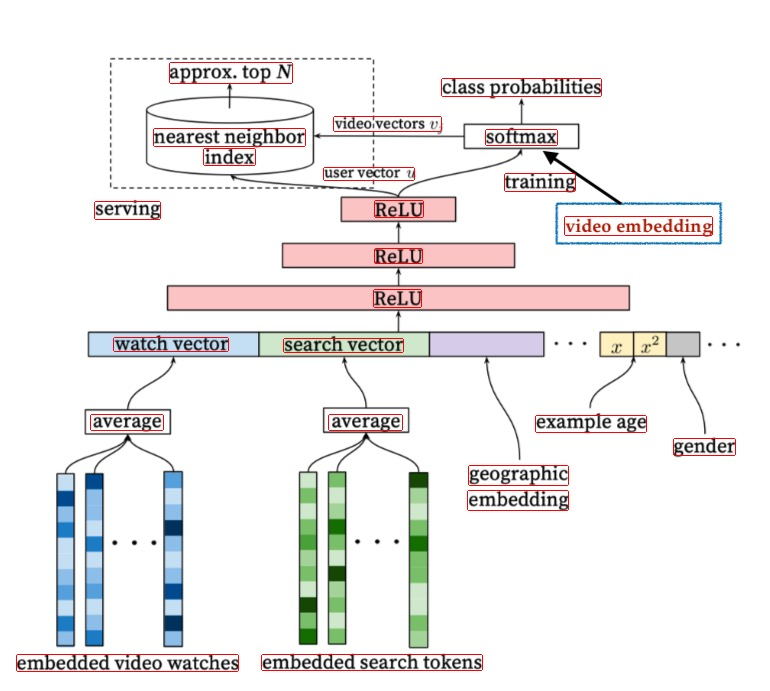

### word2vec 代码实现



In [1]:
import collections
import math
import numpy as np
import os
import random
import tensorflow as tf
import zipfile
from matplotlib import pylab
from six.moves import range
from six.moves.urllib.request import urlretrieve
from sklearn.manifold import TSNE

In [2]:
#超参数
vocabulary_size = 50000
num_steps = 100000

batch_size = 128
embedding_size = 128 # 
skip_window = 1 # 
num_skips = 2 # 
valid_size = 16 # 
valid_window = 100 #
valid_examples = np.array(random.sample(range(valid_window), valid_size))
num_sampled = 64 #

In [3]:
# 定义相关函数

# 读取数据函数
def read_data(filename):
    with zipfile.ZipFile(filename) as f:
        data = tf.compat.as_str(f.read(f.namelist()[0])).split()
    return data

# 构造训练数据
# 参数：词库
# 返回值
# data 词库的数字表达list
#  count 词频
# dictionary 词2数字的映射
# reverse_dictionary 数字 2 词的映射
def build_dataset(words):
    #统计每个词出现的次数
    count = [['UNK',-1]]
    count.extend(collections.Counter(words).most_common(vocabulary_size - 1))
    #单词 2 数字的映射
    dictionary = dict()
    for word,_ in count:
        dictionary[word] = len(dictionary)
    #把低频单词用UNK替代，提取文章的数字表示，统计UNK的数量
    data = list()
    unk_count = 0
    for word in words:
        if word in dictionary:
            index = dictionary[word]
        else:
            index = 0
            unk_count += 0
        data.append(index)
    count[0][1] = unk_count
    # 数字 2 词 的映射
    reverse_dictionary = dict(zip(dictionary.values(),dictionary.keys()))
    
    return data, count, dictionary, reverse_dictionary
  
# 定义生成训练数据的方法
# 参数
#  batch_size ：批次大小
#  num_skips ： 跳跃大小
#  skip_window ： 窗口
def generate_batch(batch_size,num_skips,skip_window):
    global data_index
    assert batch_size % num_skips == 0
    assert num_skips <= 2 * skip_window
    
    batch = np.ndarray(shape=(batch_size), dtype=np.int32)
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
    
    span = 2 * skip_window + 1 #上下文大小
    buffer = collections.deque(maxlen=span)
    for _ in range(span):
        buffer.append(data[data_index])
        # 循环使用
        data_index = (data_index + 1) % len(data)
    for i in range(batch_size // num_skips):
        
        target = skip_window  # 
        targets_to_avoid = [ skip_window ]
        for j in range(num_skips):
            while target in targets_to_avoid:
                target = random.randint(0, span - 1)
            targets_to_avoid.append(target)
            batch[i * num_skips + j] = buffer[skip_window]
            labels[i * num_skips + j, 0] = buffer[target]
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    return batch, labels  

In [4]:
words = read_data('text8.zip')
print('Data size %d' % len(words))

Data size 17005207


In [5]:
#映射之后的训练数据
data, count, dictionary, reverse_dictionary = build_dataset(words)
#打印信息
print('Most common words (+UNK)', count[:5])
print('original data', words[:10])
print('training data', data[:10])

Most common words (+UNK) [['UNK', 0], ('the', 1061396), ('of', 593677), ('and', 416629), ('one', 411764)]
original data ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against']
training data [5234, 3081, 12, 6, 195, 2, 3134, 46, 59, 156]


In [6]:
print('data:', [reverse_dictionary[di] for di in data[:8]])
data_index = 0
batch, labels = generate_batch(batch_size=8, num_skips=2, skip_window=2)
print('    batch:', [reverse_dictionary[bi] for bi in batch])
print('    labels:', [reverse_dictionary[li] for li in labels.reshape(8)])

data: ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first']
    batch: ['as', 'as', 'a', 'a', 'term', 'term', 'of', 'of']
    labels: ['a', 'originated', 'of', 'originated', 'abuse', 'a', 'first', 'term']


In [7]:
# 定义网络
graph = tf.Graph()

with graph.as_default(), tf.device('/cpu:0'):
    
    # 定义训练数据占位符
    train_dataset = tf.placeholder(tf.int32, shape=[batch_size]) #x
    train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1]) #y
    valid_dataset = tf.constant(valid_examples, dtype=tf.int32) # 验证数据
    
    #定义变量
    embeddings = tf.Variable(tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0)) #embedding
    softmax_weights = tf.Variable(tf.truncated_normal([vocabulary_size, embedding_size],stddev=1.0 / math.sqrt(embedding_size))) # 权重
    softmax_biases = tf.Variable(tf.zeros([vocabulary_size])) # 偏置项
    
    #本次训练的额对应的embedding
    embed = tf.nn.embedding_lookup(embeddings, train_dataset)
    
    #损失函数
    loss = tf.reduce_mean(
    tf.nn.sampled_softmax_loss(weights=softmax_weights, biases=softmax_biases, inputs=embed,
                               labels=train_labels, num_sampled=num_sampled, num_classes=vocabulary_size))
    
    #优化损失
    optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)
    
    #embedding 归一化
    norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
    normalized_embeddings = embeddings / norm
    
    #用已有embedding计算valid的相似度
    valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings, valid_dataset)
    similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings))

In [8]:
# 训练网络

with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    
    average_loss = 0
    for step in range(num_steps+1):
        #获取训练数据
        batch_data, batch_labels = generate_batch(batch_size, num_skips, skip_window)
        feed_dict = {train_dataset : batch_data, train_labels : batch_labels}
        _, l = session.run([optimizer, loss], feed_dict=feed_dict)
        
        average_loss += l
        #2000次打印一次日志
        if step % 2000 == 0:
            if step > 0:
                average_loss = average_loss / 2000
                print('Average loss at step %d: %f' % (step, average_loss))
                average_loss = 0
                
        # 打印valid效果
        if step % 10000 == 0:
            sim = similarity.eval()
            for i in range(valid_size):
                valid_word = reverse_dictionary[valid_examples[i]]
                top_k = 5
                nearest = (-sim[i, :]).argsort()[1:top_k+1]
                log = 'Nearest to %s:' % valid_word
                for k in range(top_k):
                    close_word = reverse_dictionary[nearest[k]]
                    log = '%s %s,' % (log, close_word)
                print(log)
                
    final_embeddings = normalized_embeddings.eval()     

Nearest to other: karabakh, partition, cheerful, pulitzer, juror,
Nearest to would: synthetic, undertakes, implicate, unfavourably, gru,
Nearest to seven: piping, rood, wolfhounds, cameroun, soft,
Nearest to however: absurdist, bother, burckhardt, yosemite, kanal,
Nearest to by: unsure, miscellany, bnls, witt, empty,
Nearest to they: osage, chases, avon, summarize, ega,
Nearest to be: quarantine, haakon, composers, empirically, sundial,
Nearest to at: mixes, rebekah, indulge, homininae, scanty,
Nearest to united: devi, modesty, inapplicable, revolutionize, chewing,
Nearest to three: jute, ecole, portfolio, marija, fjords,
Nearest to i: toyota, permitting, previously, mandeville, lost,
Nearest to in: substitutions, proust, inner, observer, absalom,
Nearest to or: mixtures, bagdad, slim, tunneling, ludo,
Nearest to over: shack, waters, untouchable, supine, fogo,
Nearest to only: antisense, stockpiling, manly, theseus, deficit,
Nearest to often: lifted, gif, downside, frisian, alertness,


Average loss at step 72000: 3.375073
Average loss at step 74000: 3.352053
Average loss at step 76000: 3.318825
Average loss at step 78000: 3.344817
Average loss at step 80000: 3.378230
Nearest to other: various, some, different, others, many,
Nearest to would: will, could, can, may, must,
Nearest to seven: eight, six, five, four, nine,
Nearest to however: but, although, though, that, while,
Nearest to by: through, repudiating, when, using, sanctioning,
Nearest to they: we, there, he, you, it,
Nearest to be: been, being, become, have, savile,
Nearest to at: near, chicxulub, during, id, in,
Nearest to united: inapplicable, dreamlike, liquor, city, modesty,
Nearest to three: six, five, four, eight, seven,
Nearest to i: ii, we, you, g, they,
Nearest to in: during, until, within, on, throughout,
Nearest to or: and, than, while, lansbury, randi,
Nearest to over: between, pitaka, around, about, within,
Nearest to only: clerihew, ying, otherwise, respectful, franchised,
Nearest to often: somet

### 在线召回 VS 离线召回

* 离线方式召回
    * 实现方式：离线计算好item2item 相似度，或者其他其他业务规则，存储到数据库倒排表
    
    * 缺点：
        * 并发
        * 慢
        
    * 改进：
        * 使用NoSql数据库，比较快
            * hbase 分布式，持久化，用于存储大数据
            * redis，内存存储，速度快，常用于缓存
            
* 实时召回
 
     *  架构：
     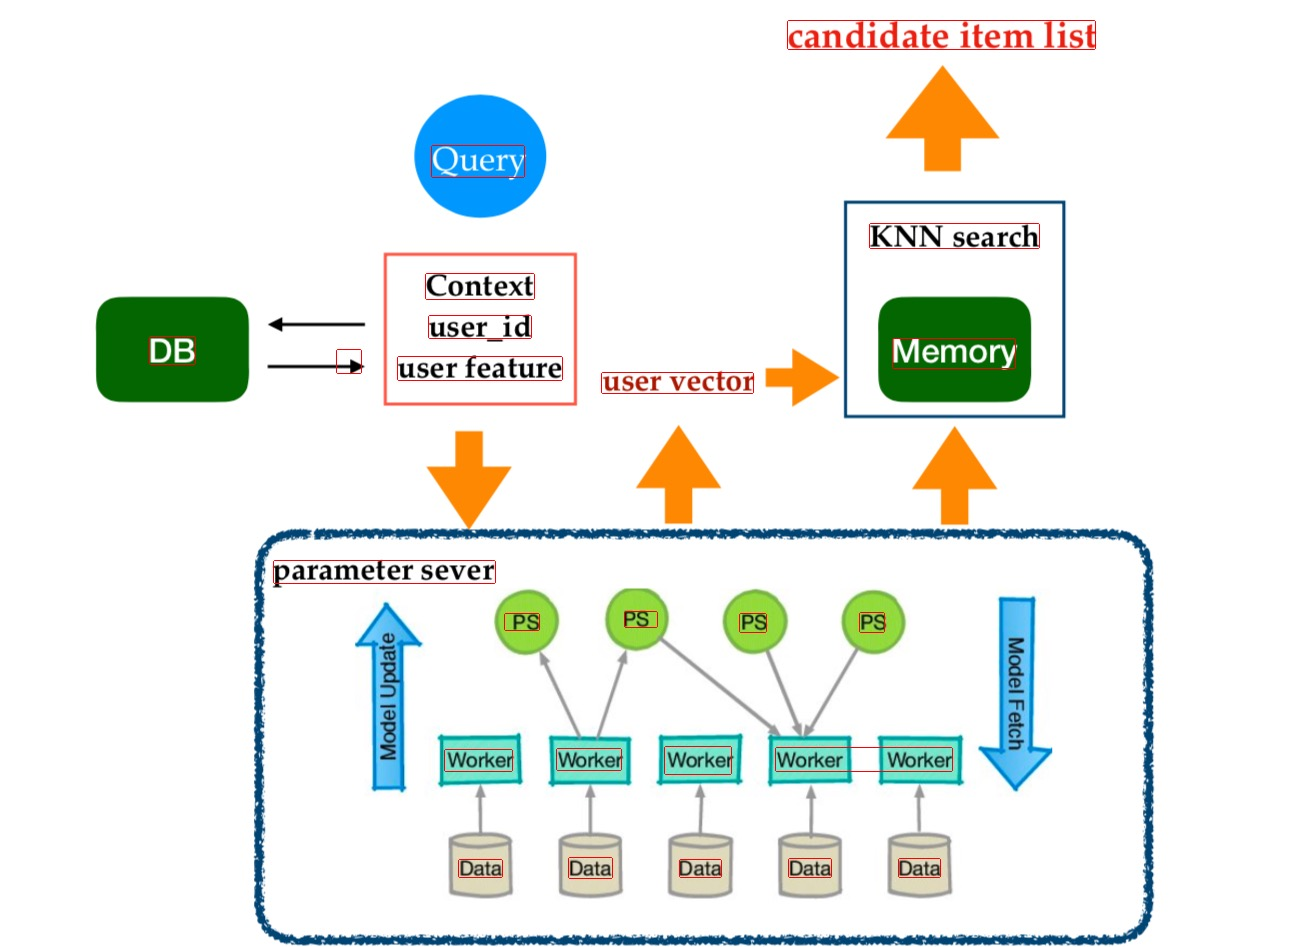
     
     * 架构描述：
     
     * 暴力召回： k近邻召回，暴力计算每个item的 相似度 ，如果item量大效率非常低
     
     *  优化召回
     
         * 局部敏感哈希（LSH）:让相似的数据打在一个桶内
             * 解决问题：在海量高维度数据集中寻找与某个数据相似（距离最近）的一个或者几个数据
             * 问题难点：将相同数据映射到同一个桶内
         
         * k-d tree (k 维 树)：
             
             
         * ball tree :
             
             
         * 只计算部分类别下的距离   